**TO DO**  
-follow this tutorial to handle date data: https://ibexorigin.medium.com/in-depth-guide-to-building-custom-sklearn-transformers-for-any-data-preprocessing-scenario-33450f8b35ff  
-Tune the model  
-Test other fill methods  
-**GRADIENT BOOSTING TREE**  
-Drop outliers?  
-**XGBOOST** https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7  
**PCA**? https://www.kaggle.com/code/carlosdg/xgboost-with-scikit-learn-pipeline-gridsearchcv  
**Pipeline improvement** https://www.kdnuggets.com/2022/07/scikitlearn-imputer.html

deviance 16.5 deviance, 6.8 deviance with gradient bosyng optimize deviance! AMS got 5.8...

In [114]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
from custom_scorer_module import custom_accuracy
%matplotlib inline
import pickle
from langdetect import detect
from sklearn.metrics import fbeta_score, make_scorer, mean_poisson_deviance
%load_ext autoreload
%autoreload 2
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
def accuracy(y_pred,y,tol=0):
    numpy_y=y.to_numpy()
    rounded_y_pred=y_pred.round()
    assert len(rounded_y_pred)==len(numpy_y)
    return (np.abs(rounded_y_pred-numpy_y)<=tol).sum()/len(rounded_y_pred)

In [116]:
def evaluate_model(y_true,y_pred):
    prediction=y_pred.copy()
    prediction[prediction<=0]=10**(-10)
    return mean_poisson_deviance(y_true,prediction)
    

In [117]:
#scoring=make_scorer(custom_accuracy, tol=0,greater_is_better=True)
scoring=make_scorer(evaluate_model,greater_is_better=False)

In [118]:
seed=np.random.randint(100)
DICT_GEO_CANTON={'ZH':0, 'VD':1, 'BE':2, 'AG':3, 'FR':4, 'SG':5, 'LU':6, 'SO':7, 'SH':8, 'GE':9, 'VS':10,
       'SZ':11, 'BS':12, 'ZG':13, 'BL':14, 'NE':15, 'TI':16, 'GR':17, 'TG':18, 'AR':19, 'UR':20, 'GL':21,
       'NW':22, 'JU':22}
DICT_SUBCATEGORY={'Apartment':0, 'Duplex':1, 'Row house':2, 'Roof flat':3, 'Attic flat':4,
       'Single house':5, 'Single Room':6, 'Studio':7, 'Furnished dwelling':8,
       'Loft':9, 'Mansard':10, 'Farm house':11}

In [119]:
with open("./listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open("./test_listings_overall.pkl", "rb") as fh:
    data_test = pickle.load(fh)

In [120]:
data

,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Demand,Floor,Geo Canton,Geo City,Geo Zip,Has Balcony,...,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated
0,NaN,APPT,"January 7, 2021","March 1, 2021",25.0,0.0,ZH,Dübendorf,8600,NaN,...,6,550.0,4460.0,19.0,3910.0,0002.03.7648,232.0,Apartment,2016.0,2016.0
1,NaN,APPT,"November 18, 2019","March 1, 2020",2.0,1.0,VD,Le Mont-sur-Lausanne,1052,NaN,...,7,120.0,1345.0,30.0,1225.0,9680.61.2071,45.0,Apartment,NaN,NaN
2,False,APPT,"March 15, 2017",NaN,0.0,1.0,BE,Langenthal,4900,False,...,13,250.0,1570.0,15.0,1320.0,7204.61.8658,103.0,Apartment,NaN,NaN
3,True,APPT,"July 7, 2021","May 1, 2021",4.0,1.0,AG,Fislisbach,5442,NaN,...,13,270.0,1480.0,17.0,1210.0,7410.50.5987,86.0,Apartment,1985.0,1985.0
4,False,APPT,"November 3, 2017","August 1, 2017",3.0,0.0,FR,Bulle,1630,False,...,3,300.0,1490.0,19.0,1190.0,9270.61.7822,79.0,Apartment,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,APPT,"January 4, 2018","April 1, 2018",2.0,2.0,SG,St. Gallen,9000,False,...,6,170.0,1350.0,15.0,1180.0,4458.50.0065,90.0,Apartment,NaN,NaN
19996,True,APPT,"November 3, 2021","February 1, 2022",1.0,2.0,VD,Vevey,1800,NaN,...,8,190.0,1940.0,23.0,1750.0,4481.61.5904,84.0,Apartment,1968.0,1968.0
19997,NaN,APPT,"October 15, 2021","June 16, 2021",2.0,5.0,GE,Grand-Lancy,1212,NaN,...,5,275.0,2175.0,32.0,1900.0,0221.61.7685,68.0,Apartment,NaN,NaN
19998,NaN,APPT,"October 1, 2020","May 1, 2021",2.0,7.0,VD,Nyon,1260,NaN,...,6,240.0,3540.0,37.0,3300.0,8508.50.4399,95.0,Apartment,NaN,NaN


In [121]:
list(data)

['Are Pets Allowed',
 'Category Idx',
 'Day of Advertisement Created',
 'Day of Date Available From',
 'Demand',
 'Floor',
 'Geo Canton',
 'Geo City',
 'Geo Zip',
 'Has Balcony',
 'Has Cabletv',
 'Has Elevator',
 'Has Fireplace',
 'Has Garage',
 'Has Parking',
 'Is New Construction',
 'Is New Construction Potential',
 'Is Tenant2Tenant',
 'Is Wheelchairaccessible',
 'Listing Description',
 'Listing Title',
 'Livingspace',
 'Number Of Rooms',
 'Number Of Rooms Cleaned',
 'Number of Documents',
 'Number of Images',
 'Price Extra Normalized',
 'Price Gross Normalized',
 'Price M2 Normalized',
 'Price Net Normalized',
 'Property Reference Id',
 'Size M2 Normalized',
 'Subcategory En Idx',
 'Year Built',
 'Year Lastrenovated']

<AxesSubplot:>

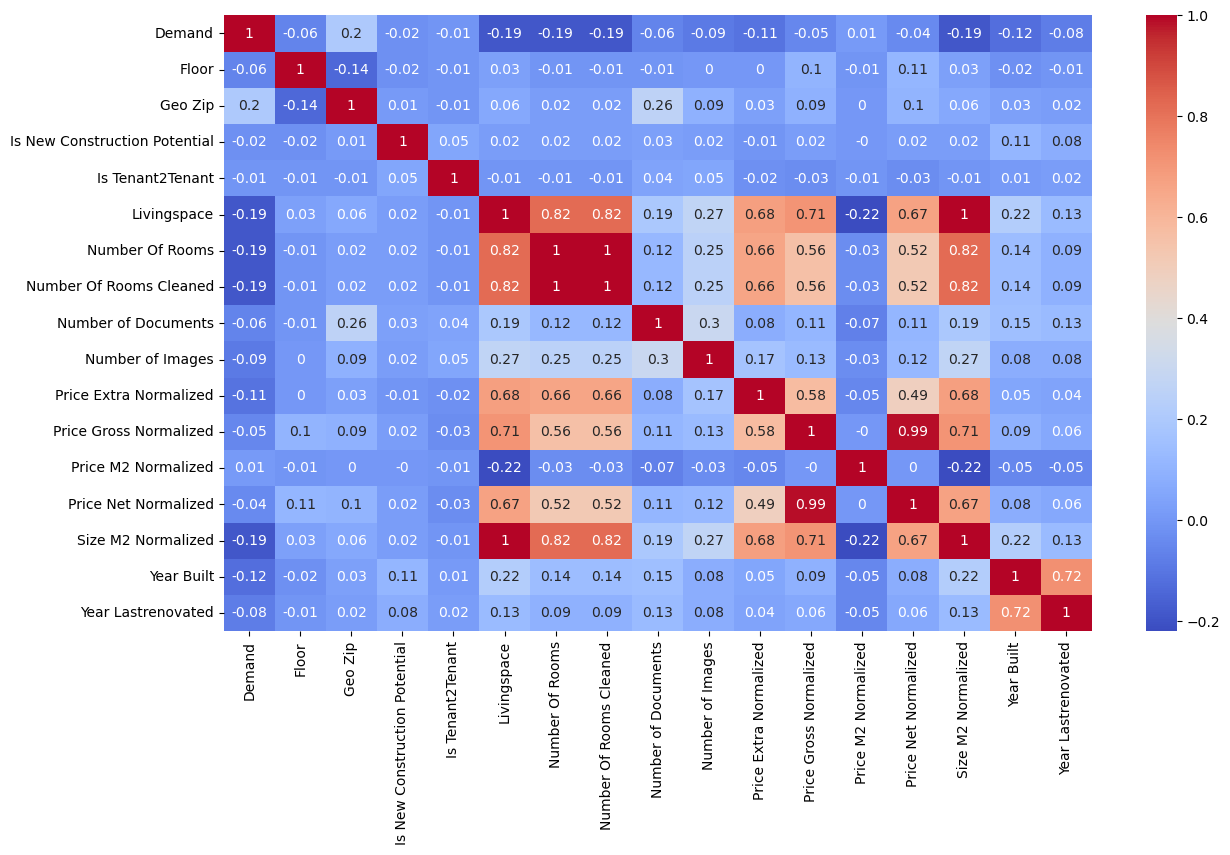

In [122]:
# Plot the correlation heatmap
plt.figure(figsize=(14, 8))
corr_matrix = data.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

**Conclusion** We should remove one of the corrolated variables ex: remove Number of Rooms Cleaned, Livingscapce Price net normalized

In [123]:
data['Demand'].value_counts()[data['Demand'].value_counts()>20]

0.0     4476
1.0     2644
2.0     2057
3.0     1539
4.0     1190
5.0      922
6.0      726
7.0      647
8.0      547
9.0      479
10.0     400
11.0     349
12.0     296
13.0     275
14.0     250
15.0     218
16.0     182
17.0     177
18.0     158
19.0     155
21.0     137
20.0     130
22.0     117
25.0      93
24.0      90
23.0      87
27.0      82
28.0      70
26.0      67
30.0      66
29.0      64
31.0      63
34.0      58
33.0      54
32.0      47
35.0      46
36.0      44
38.0      41
37.0      39
41.0      39
44.0      36
43.0      30
42.0      29
40.0      29
39.0      29
55.0      29
45.0      28
48.0      27
49.0      25
51.0      25
56.0      24
50.0      23
47.0      23
46.0      23
52.0      22
54.0      21
Name: Demand, dtype: int64

# Data Cleaning

There are some things to consider before starting using the random forest:  
1-**How to deal with NaN**  
  Answer: check if there are NaN in test set, if yes can make a category for NaN?  
          What does NaN mean? Customer doesn't have access to the information? Or we don't know if he had access to it?  
2-**How to deal with categorical variables**  
  One hot encoding, but beware of having too many categories.  
  Testing without categorical variables?  

## Identifying categorical and categorical variables

In [124]:
#identifying the boolean variables
bool_features=['Are Pets Allowed', 'Has Balcony', 'Has Cabletv',
               'Has Elevator', 'Has Fireplace', 'Has Garage',
               'Has Parking', 'Is New Construction', 'Is New Construction Potential', 
               'Is Tenant2Tenant', 'Is Wheelchairaccessible']
print(bool_features)
data_bool=data[bool_features]

['Are Pets Allowed', 'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace', 'Has Garage', 'Has Parking', 'Is New Construction', 'Is New Construction Potential', 'Is Tenant2Tenant', 'Is Wheelchairaccessible']


Identifying other categorical (and non ordinal ex: Number of Rooms, Price Extra Normalized or even Year Built...) variables with not so many categories

In [125]:
data.nunique()[data.nunique()>2]

Day of Advertisement Created     1483
Day of Date Available From        255
Demand                            172
Floor                              22
Geo Canton                         24
Geo City                          392
Geo Zip                           450
Listing Description             17822
Listing Title                   11224
Livingspace                       206
Number Of Rooms                    19
Number Of Rooms Cleaned            19
Number of Documents                 3
Number of Images                   14
Price Extra Normalized            413
Price Gross Normalized           1873
Price M2 Normalized               157
Price Net Normalized             1410
Property Reference Id           14699
Size M2 Normalized                205
Subcategory En Idx                 12
Year Built                        143
Year Lastrenovated                136
dtype: int64

In [126]:
#This feature is not supposed to be useful for regression purpose
data['Property Reference Id']

0        0002.03.7648
1        9680.61.2071
2        7204.61.8658
3        7410.50.5987
4        9270.61.7822
             ...     
19995    4458.50.0065
19996    4481.61.5904
19997    0221.61.7685
19998    8508.50.4399
19999    4893.61.5829
Name: Property Reference Id, Length: 20000, dtype: object

### Investigating the NaN

In [127]:
#Will see later how to handle those
other_categorical_features=['Category Idx','Geo City','Geo Zip']
data=data.drop(other_categorical_features,axis=1)
data_test=data_test.drop(other_categorical_features,axis=1)


#The ordinal features are:
ordinal_features=['Floor','Livingspace', 'Number Of Rooms',
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 
       'Size M2 Normalized', 'Year Built',
       'Year Lastrenovated']

categorical_features={'Geo Canton':DICT_GEO_CANTON,'Subcategory En Idx':DICT_SUBCATEGORY}

#Which leaves us with 'Property Reference Id ',Listing Description' and 'Listing Title' which we will not use for regression purpose
data=data.drop(['Property Reference Id','Listing Description','Listing Title'],axis=1)
data_test=data_test.drop(['Property Reference Id','Listing Description','Listing Title'],axis=1)


In [128]:
null_count=pd.concat([data.isnull().sum().rename('NaN train set'),data_test.isnull().sum().rename('NaN test set')],axis=1)
null_count

,NaN train set,NaN test set
Are Pets Allowed,9267.0,4554.0
Day of Advertisement Created,0.0,0.0
Day of Date Available From,3555.0,1783.0
Demand,0.0,NaN
Floor,7.0,4.0
Geo Canton,0.0,0.0
Has Balcony,12110.0,5962.0
Has Cabletv,7151.0,3561.0
Has Elevator,7585.0,3728.0
Has Fireplace,12179.0,6022.0


In [129]:
iter_imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),random_state=42,max_iter=20)

In [130]:
temp=data.copy()

In [131]:
iter_imputed = iter_imputer.fit_transform(data[ordinal_features])
iter_imputed

C:\Users\Corentin\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[0.0000e+00, 2.3200e+02, 9.5000e+00, ..., 2.3200e+02, 2.0160e+03,
        2.0160e+03],
       [1.0000e+00, 4.5000e+01, 2.5000e+00, ..., 4.5000e+01, 1.9689e+03,
        1.9934e+03],
       [1.0000e+00, 1.0300e+02, 3.5000e+00, ..., 1.0300e+02, 1.9794e+03,
        1.9873e+03],
       ...,
       [5.0000e+00, 6.8000e+01, 4.0000e+00, ..., 6.8000e+01, 1.9721e+03,
        1.9705e+03],
       [7.0000e+00, 9.5000e+01, 4.5000e+00, ..., 9.5000e+01, 1.9555e+03,
        1.9758e+03],
       [0.0000e+00, 5.2000e+01, 2.0000e+00, ..., 5.2000e+01, 1.9863e+03,
        1.9850e+03]])

In [132]:
temp.loc[:,ordinal_features]=iter_imputed

In [133]:
temp

,Are Pets Allowed,Day of Advertisement Created,Day of Date Available From,Demand,Floor,Geo Canton,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,...,Number of Documents,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated
0,NaN,"January 7, 2021","March 1, 2021",25.0,0.0,ZH,NaN,NaN,NaN,NaN,...,1.0,6.0,550.0,4460.0,19.0,3910.0,232.0,Apartment,2016.0,2016.0
1,NaN,"November 18, 2019","March 1, 2020",2.0,1.0,VD,NaN,NaN,NaN,NaN,...,0.0,7.0,120.0,1345.0,30.0,1225.0,45.0,Apartment,1968.9,1993.4
2,False,"March 15, 2017",NaN,0.0,1.0,BE,False,False,False,False,...,1.0,13.0,250.0,1570.0,15.0,1320.0,103.0,Apartment,1979.4,1987.3
3,True,"July 7, 2021","May 1, 2021",4.0,1.0,AG,NaN,True,NaN,NaN,...,1.0,13.0,270.0,1480.0,17.0,1210.0,86.0,Apartment,1985.0,1985.0
4,False,"November 3, 2017","August 1, 2017",3.0,0.0,FR,False,False,False,False,...,0.0,3.0,300.0,1490.0,19.0,1190.0,79.0,Apartment,1986.5,1994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,"January 4, 2018","April 1, 2018",2.0,2.0,SG,False,False,False,False,...,1.0,6.0,170.0,1350.0,15.0,1180.0,90.0,Apartment,1971.4,1984.2
19996,True,"November 3, 2021","February 1, 2022",1.0,2.0,VD,NaN,True,True,NaN,...,0.0,8.0,190.0,1940.0,23.0,1750.0,84.0,Apartment,1968.0,1968.0
19997,NaN,"October 15, 2021","June 16, 2021",2.0,5.0,GE,NaN,NaN,NaN,NaN,...,0.0,5.0,275.0,2175.0,32.0,1900.0,68.0,Apartment,1972.1,1970.5
19998,NaN,"October 1, 2020","May 1, 2021",2.0,7.0,VD,NaN,NaN,NaN,NaN,...,1.0,6.0,240.0,3540.0,37.0,3300.0,95.0,Apartment,1955.5,1975.8


**Conclusion**: We see that test data have nan for the same attributes as for train data, so for categorical variables we can encode nan as a category

We then see that there are NaN values for ordinal features, this is bad as we can't add a category for ordinal values. We will have to fill them by the mean of the other values in the column for example

In [134]:
#null_count.loc[ordinal_features]

In [135]:
#null_count.loc[bool_features]

# Preprocessing pipeline with one hot encoding

In [136]:
#https://towardsdatascience.com/predicting-housing-prices-using-a-scikit-learns-random-forest-model-e736b59d56c5
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer


In [137]:
#Deal with 'Day of Advertisement Created' and 'Day of Date Available From'
def compute_diff_date(X: pd.DataFrame, y=None):
    X_copy=X.copy()
    threshold=datetime.datetime(2022,9,1)
    X_copy['Days Between September and Created']=pd.to_datetime(X_copy['Day of Advertisement Created']).apply(lambda x:(threshold-x).days)
    X_copy['Days Between September and Available']=pd.to_datetime(X_copy['Day of Date Available From']).apply(lambda x:(threshold-x).days)                                                           
    X_copy.drop(['Day of Advertisement Created','Day of Date Available From'],axis=1,inplace=True)
    return X_copy

diff_date_transformer = FunctionTransformer(compute_diff_date)

print('Dealing with date')
display(diff_date_transformer.transform(data))

Dealing with date


,Are Pets Allowed,Demand,Floor,Geo Canton,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,Has Garage,Has Parking,...,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Days Between September and Created,Days Between September and Available
0,NaN,25.0,0.0,ZH,NaN,NaN,NaN,NaN,NaN,NaN,...,550.0,4460.0,19.0,3910.0,232.0,Apartment,2016.0,2016.0,602,549.0
1,NaN,2.0,1.0,VD,NaN,NaN,NaN,NaN,NaN,NaN,...,120.0,1345.0,30.0,1225.0,45.0,Apartment,NaN,NaN,1018,914.0
2,False,0.0,1.0,BE,False,False,False,False,False,False,...,250.0,1570.0,15.0,1320.0,103.0,Apartment,NaN,NaN,1996,NaN
3,True,4.0,1.0,AG,NaN,True,NaN,NaN,True,True,...,270.0,1480.0,17.0,1210.0,86.0,Apartment,1985.0,1985.0,421,488.0
4,False,3.0,0.0,FR,False,False,False,False,False,False,...,300.0,1490.0,19.0,1190.0,79.0,Apartment,NaN,NaN,1763,1857.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,2.0,2.0,SG,False,False,False,False,False,False,...,170.0,1350.0,15.0,1180.0,90.0,Apartment,NaN,NaN,1701,1614.0
19996,True,1.0,2.0,VD,NaN,True,True,NaN,True,True,...,190.0,1940.0,23.0,1750.0,84.0,Apartment,1968.0,1968.0,302,212.0
19997,NaN,2.0,5.0,GE,NaN,NaN,NaN,NaN,NaN,NaN,...,275.0,2175.0,32.0,1900.0,68.0,Apartment,NaN,NaN,321,442.0
19998,NaN,2.0,7.0,VD,NaN,NaN,NaN,NaN,NaN,NaN,...,240.0,3540.0,37.0,3300.0,95.0,Apartment,NaN,NaN,700,488.0


In [138]:
categorical_features={'Geo Canton':DICT_GEO_CANTON,'Subcategory En Idx':DICT_SUBCATEGORY}

In [139]:
#DEALING WITH NAN
def fill_nan(X: pd.DataFrame,bool_features,categorical_features,ordinal_features,bool_fill=-99999, y=None):
    df=X.copy() #We don't want to modify the dataset
    
    #Dealing with categorical values
    for bool_feature in bool_features:
        df.loc[:,bool_feature]=df.loc[:,bool_feature].fillna(bool_fill)
        df.loc[df[bool_feature] == False, bool_feature] = 0
        df.loc[data[bool_feature] == True, bool_feature] = 1
    
    #Dealing with ordinal values
    for ordinal_feature in ordinal_features:
        df[ordinal_feature].fillna(df[ordinal_feature].mean(),inplace=True)
        
    #Dealing with categorical features
    for categorical_feature in categorical_features.keys():
        dict_replace=categorical_features[categorical_feature]
        df[categorical_feature]=df[categorical_feature].replace(dict_replace)
        df[categorical_feature].fillna(len(dict_replace)+1,inplace=True)
        #df[categorical_feature].fillna(bool_fill,inplace=True)
    return df

na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'categorical_features':categorical_features,
                                'ordinal_features':ordinal_features+['Days Between September and Created',
                                                                     'Days Between September and Available']})



In [140]:
#One Hot Encoding
features_to_encode=bool_features
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )
print('One Hot Encoded data:')
print(col_trans.fit_transform(na_fill_estimator.transform(diff_date_transformer.transform(data))))
print(col_trans.fit_transform(na_fill_estimator.transform(diff_date_transformer.transform(data))).shape)

One Hot Encoded data:
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.0160000e+03
  6.0200000e+02 5.4900000e+02]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.9917911e+03
  1.0180000e+03 9.1400000e+02]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.9917911e+03
  1.9960000e+03 1.0280996e+03]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.9917911e+03
  3.2100000e+02 4.4200000e+02]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.9917911e+03
  7.0000000e+02 4.8800000e+02]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.9917911e+03
  1.9390000e+03 1.8260000e+03]]
(20000, 49)


# PCA

In [141]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
rf_regressor=RandomForestRegressor(oob_score=True,
                      n_jobs=-1)
preprocess_pipe=make_pipeline(diff_date_transformer,na_fill_estimator, col_trans)
pipeline = Pipeline([
    ('preprocessing', preprocess_pipe), 
    ('pca', PCA()), 
    ('model', rf_regressor)
])



In [142]:
#Generating test and train set
X=data.drop('Demand',axis=1)
#X=data[data['Demand']<=60].drop(['Demand'],axis=1)
y=data['Demand']
#y=y[y<=60]
#seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, 
                                                    random_state = seed
                                                   )
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(13340, 28) (13340,) (6660, 28) (6660,)


In [143]:
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipeline,X,y,cv=5,scoring=scoring).mean())

Out of sample mean poisson deviance by cross validation: -7.724500380396333


In [144]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function compute_diff_date at 0x000001BB4B3ED0D0>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function fill_nan at 0x000001BB4B3ED940>,
                                                      kw_args={'bool_features': ['Are '
                                                                                 'Pets '
                                                                                 'Allowed',
                                                                                 'Has '
                                                                                 'Balcony',
                                                                                 'Has '
                                                                                 'Cabletv',
    

In [145]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipeline.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipeline.predict(X_test))))

In Sample mean poisson deviance 1.5480
Out of Sample mean poisson deviance 7.5599


In [146]:
preprocess_pipe=make_pipeline(diff_date_transformer,na_fill_estimator)
pipeline = Pipeline([
    ('preprocessing', preprocess_pipe), 
    ('pca', PCA()), 
    ('model', rf_regressor)
])
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipeline,X,y,cv=5,scoring=scoring).mean())

Out of sample mean poisson deviance by cross validation: -7.910146668785967


In [147]:
pipeline.fit(X_train, y_train)
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipeline.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipeline.predict(X_test))))

In Sample mean poisson deviance 1.5438
Out of Sample mean poisson deviance 8.1676


# XGBOOST

In [148]:
#Generating test and train set
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X=data.drop(['Demand'],axis=1)
y=data['Demand']

#seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333
                                                    , random_state = seed
                                                   )
y_train = le.fit_transform(y_train)
y=le.fit_transform(y)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
model =  xgb.XGBRegressor(missing=-99999)
pipe = make_pipeline(diff_date_transformer,na_fill_estimator, col_trans,model)
pipe.fit(X_train, y_train)
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

(13340, 28) (13340,) (6660, 28) (6660,)
Out of sample mean poisson deviance by cross validation: -7.31196175161781
In Sample mean poisson deviance 3.3464
Out of Sample mean poisson deviance 8.9773


In [149]:
#WITH PCA
le = LabelEncoder()
X=data.drop(['Demand'],axis=1)
y=data['Demand']

#seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333
                                                    , random_state = seed
                                                   )

y_train = le.fit_transform(y_train)
y=le.fit_transform(y)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
model =  xgb.XGBRegressor(missing=-99999)

preprocess_pipe=make_pipeline(diff_date_transformer,na_fill_estimator,col_trans)
pipeline = Pipeline([
    ('preprocessing', preprocess_pipe), 
    ('pca', PCA()), 
    ('model', model)
])
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipeline,X,y,cv=5,scoring=scoring).mean())
pipe.fit(X_train, y_train)
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipeline.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipeline.predict(X_test))))

(13340, 28) (13340,) (6660, 28) (6660,)
Out of sample mean poisson deviance by cross validation: -15.93423608964722
In Sample mean poisson deviance 3.3464
Out of Sample mean poisson deviance 8.9773


# Random forest

In [150]:
rf_regressor=RandomForestRegressor(oob_score=True,
                      n_jobs=-1)
pipe = make_pipeline(diff_date_transformer,na_fill_estimator, col_trans,rf_regressor)

In [151]:
#Generating test and train set
X=data.drop('Demand',axis=1)
#X=data[data['Demand']<=60].drop(['Demand'],axis=1)
y=data['Demand']
#y=y[y<=60]
#seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, 
                                                    random_state = seed
                                                   )
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(13340, 28) (13340,) (6660, 28) (6660,)


In [152]:
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

Out of sample mean poisson deviance by cross validation: -6.162520707111209


In [153]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function compute_diff_date at 0x000001BB4B3ED0D0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x000001BB4B3ED940>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                  

In [154]:
#predictions=pipe.predict(data_test.drop('Prediction',axis=1))
#data_test['Prediction']=predictions
#with open("RF_prediction.pickle", "wb") as f:
#    pickle.dump(data_test, f)

In [155]:
#print(rf_regressor.feature_importances_)
#print(len(rf_regressor.feature_importances_))

We notice that there are more importance than features because of the one hot encoding

In [156]:
# Let's look at the first row
#print(col_trans.fit_transform(na_fill_estimator.transform(X_train))[0,:]) 

In [157]:
#na_fill_estimator.transform(X_train).iloc[0]

All the encoded categorical variables are shown first, followed by the numeric variables in the one hot encoded version of X_train?

In [158]:
def encode_and_bind(original_dataframe, features_to_encode):    
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(na_fill_estimator.transform(diff_date_transformer.transform(X_train)), features_to_encode)

C:\Users\Corentin\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [159]:
#X_train_encoded

In [160]:
feature_importances = list(zip(X_train_encoded, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

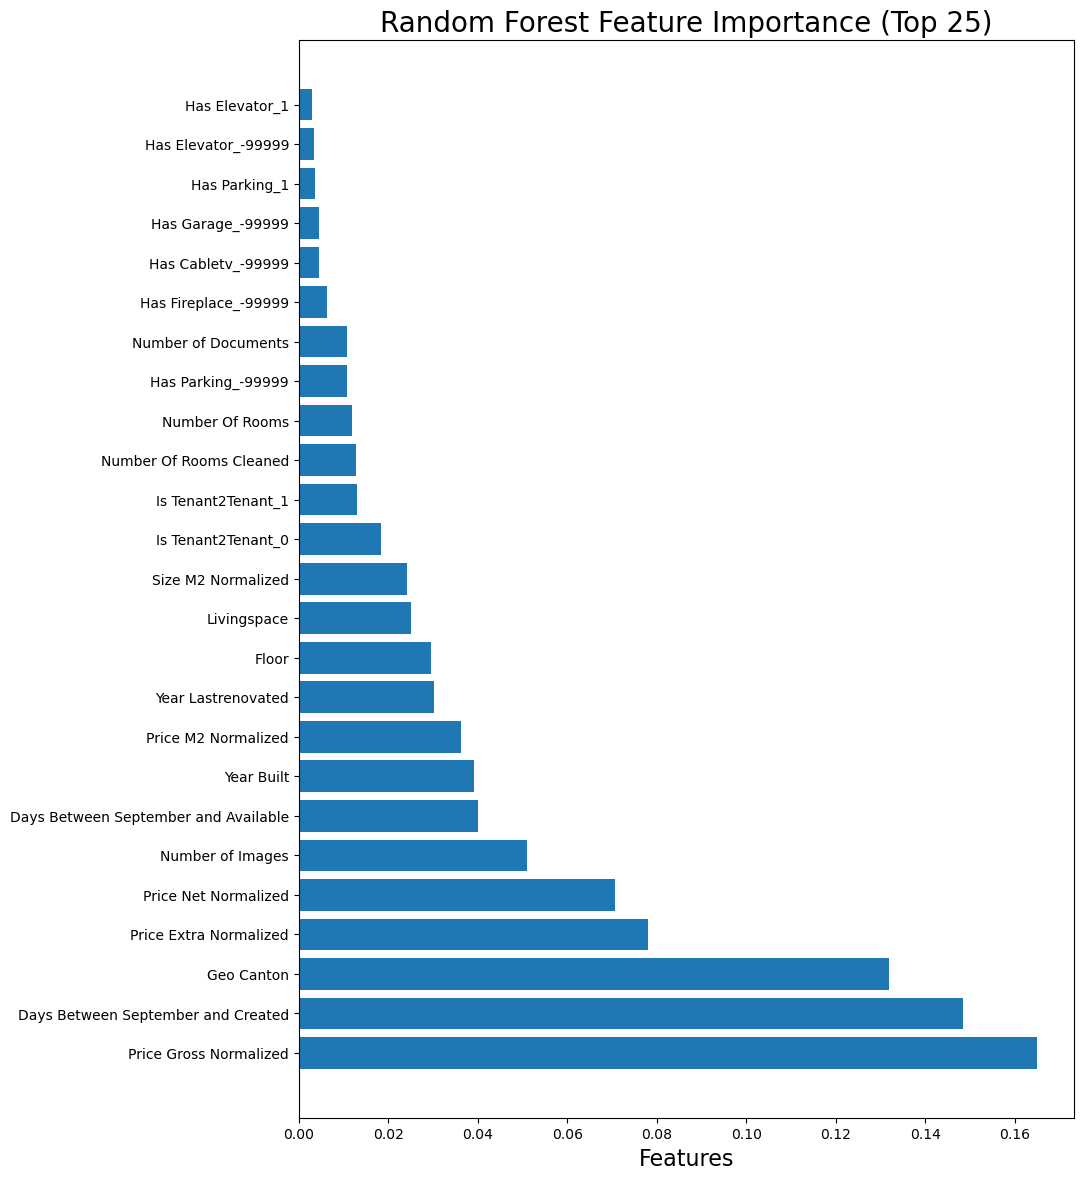

In [161]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [162]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.1965
Out of Sample mean poisson deviance 6.1825


# Random forest without one hot encoding

In [163]:
pipe = make_pipeline(diff_date_transformer,na_fill_estimator,rf_regressor)
cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean()


-6.161794278424744

In [164]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function compute_diff_date at 0x000001BB4B3ED0D0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x000001BB4B3ED940>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                  

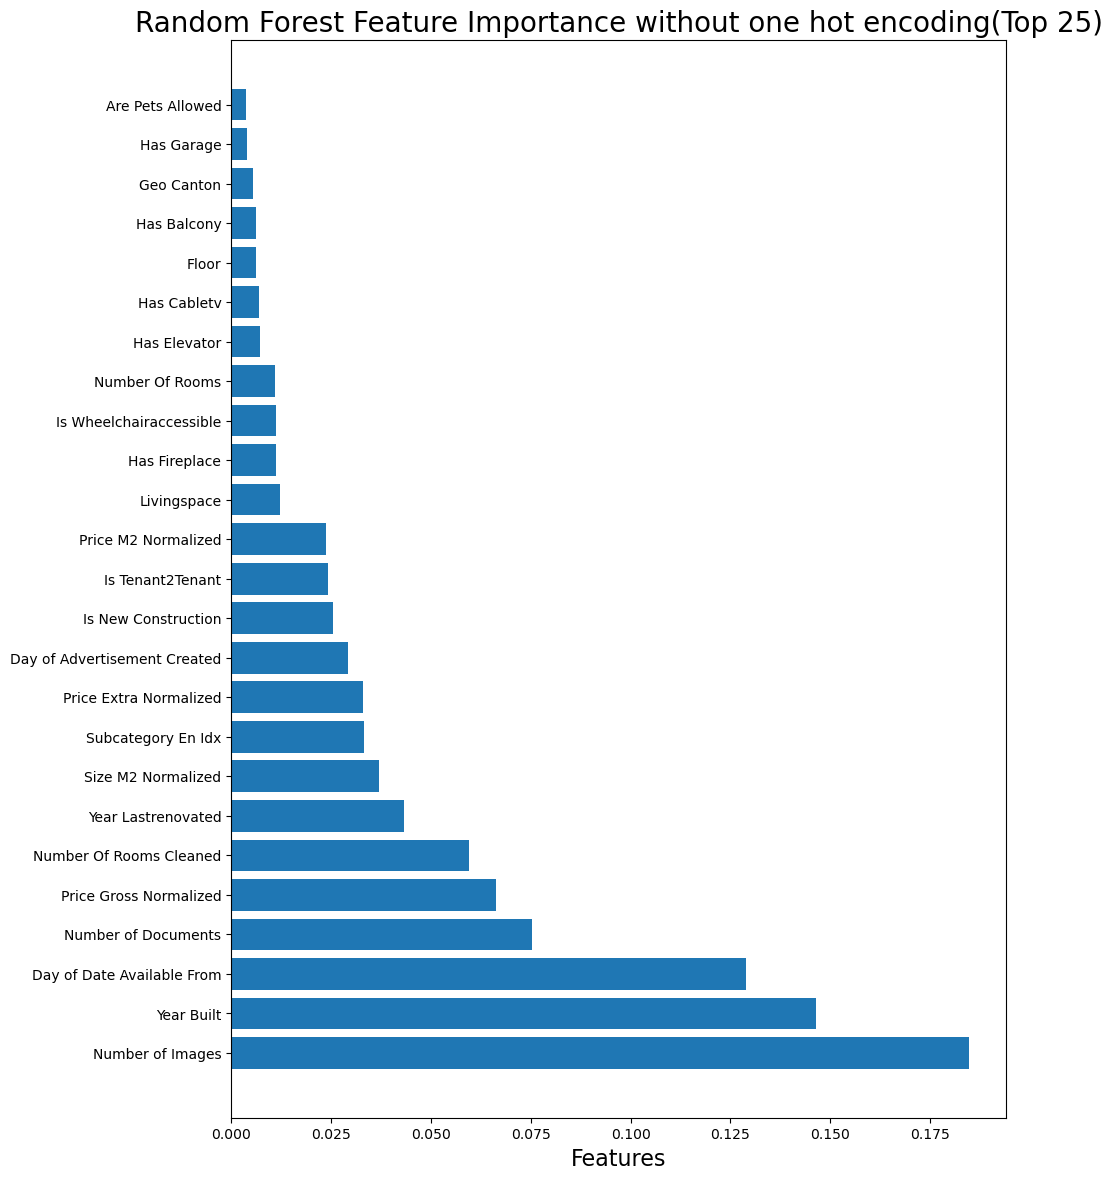

In [165]:
feature_importances = list(zip(X_train, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [166]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.1980
Out of Sample mean poisson deviance 6.2433


**Conclusion** One hot encoding leads to similar results as not one hot encoding for bool categorical variables

# Dropping the corrolated features

In [307]:
#Removing size M2 Normalized, Number of Rooms and all price measure except extra price normalized:
ordinal_features=['Floor','Livingspace', 
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Year Built',
       'Year Lastrenovated']

In [308]:
def drop_column(X: pd.DataFrame,columns, y=None):
    X_copy=X.copy() #We don't want to modify the dataset
    X_copy.drop(columns,axis=1,inplace=True)
    
    return X_copy

drop_col_transformer = FunctionTransformer(drop_column,kw_args={'columns':['Price M2 Normalized','Price Gross Normalized',
                                                                           'Price Net Normalized','Size M2 Normalized',
                                                                           'Number Of Rooms']})
na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'categorical_features':categorical_features,
                                                          'ordinal_features':ordinal_features+
                                                          ['Days Between September and Created',
                                                                     'Days Between September and Available']})

## 1 With One Hot encoding

In [77]:
pipe= make_pipeline(drop_col_transformer,diff_date_transformer,na_fill_estimator,col_trans,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_column at 0x00000127D9C5E430>,
                                     kw_args={'columns': ['Price M2 Normalized',
                                                          'Price Gross '
                                                          'Normalized',
                                                          'Price Net '
                                                          'Normalized',
                                                          'Size M2 Normalized',
                                                          'Number Of Rooms']})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function compute_diff_date at 0x00000127C5730B80>)),
                ('functiontrans...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                        

In [78]:
#X_train_encoded = encode_and_bind(na_fill_estimator.transform(diff_date_transformer.transform(drop_col_transformer.transform(X_train))), features_to_encode)
#feature_importances = list(zip(X_train_encoded, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
#feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
#y_ticks = np.arange(0, len(feature_names_25))
#x_axis = [i[1] for i in feature_importances_ranked[:25]]
#plt.figure(figsize = (10, 14))
#plt.barh(feature_names_25, x_axis)   #horizontal barplot
#plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
#          fontdict= {'fontsize' : 20})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
#plt.show()

In [79]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.2841
Out of Sample mean poisson deviance 6.7622


In [260]:
#print('Out of sample accuracy by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

C:\Users\Corentin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Out of sample accuracy by cross validation: 0.2232


## 2 Without One Hot encoding

In [80]:
pipe= make_pipeline(drop_col_transformer,diff_date_transformer,na_fill_estimator,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_column at 0x00000127D9C5E430>,
                                     kw_args={'columns': ['Price M2 Normalized',
                                                          'Price Gross '
                                                          'Normalized',
                                                          'Price Net '
                                                          'Normalized',
                                                          'Size M2 Normalized',
                                                          'Number Of Rooms']})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function compute_diff_date at 0x00000127C5730B80>)),
                ('functiontrans...
                                                                                              'Single house': 5,
                                                      

In [268]:
#feature_importances = list(zip(drop_col_transformer.transform(X_train), rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
#feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
#y_ticks = np.arange(0, len(feature_names_25))
#x_axis = [i[1] for i in feature_importances_ranked[:25]]
#plt.figure(figsize = (10, 14))
#plt.barh(feature_names_25, x_axis)   #horizontal barplot
#plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
#          fontdict= {'fontsize' : 20})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
#plt.show()

In [81]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.2865
Out of Sample mean poisson deviance 6.7921


In [82]:
#print('Out of sample accuracy by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

**Conclusion** Dropping the corrolated features didn't improve accuracy

# Tuning the Random Forest Model

## 1-Create a pipeline with the non postive value transformed in 10^-10 for the pred

In [309]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [312]:
ordinal_features=['Floor','Livingspace', 'Number Of Rooms',
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 
       'Size M2 Normalized', 'Year Built',
       'Year Lastrenovated']
na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'categorical_features':categorical_features,
                                'ordinal_features':ordinal_features+['Days Between September and Created',
                                                                     'Days Between September and Available']})

In [316]:
from sklearn.model_selection import RandomizedSearchCV
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1,2,4,7,10]
bootstrap = [True]
random_grid = {'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [317]:
rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
scoring=make_scorer(evaluate_model,greater_is_better=False)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5,                
                               verbose=10,      scoring=scoring)
pipe_random = make_pipeline(diff_date_transformer,na_fill_estimator,rf_random)
pipe_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bootstrap=True, max_features=log2, min_samples_leaf=4......
[CV 1/5; 1/10] END bootstrap=True, max_features=log2, min_samples_leaf=4;, score=-6.502 total time=   4.1s
[CV 2/5; 1/10] START bootstrap=True, max_features=log2, min_samples_leaf=4......
[CV 2/5; 1/10] END bootstrap=True, max_features=log2, min_samples_leaf=4;, score=-6.931 total time=   0.9s
[CV 3/5; 1/10] START bootstrap=True, max_features=log2, min_samples_leaf=4......
[CV 3/5; 1/10] END bootstrap=True, max_features=log2, min_samples_leaf=4;, score=-7.255 total time=   0.9s
[CV 4/5; 1/10] START bootstrap=True, max_features=log2, min_samples_leaf=4......
[CV 4/5; 1/10] END bootstrap=True, max_features=log2, min_samples_leaf=4;, score=-6.913 total time=   0.9s
[CV 5/5; 1/10] START bootstrap=True, max_features=log2, min_samples_leaf=4......
[CV 5/5; 1/10] END bootstrap=True, max_features=log2, min_samples_leaf=4;, score=-7.858 total time=   0.9s

[CV 4/5; 9/10] END bootstrap=True, max_features=0.5, min_samples_leaf=4;, score=-6.424 total time=   2.0s
[CV 5/5; 9/10] START bootstrap=True, max_features=0.5, min_samples_leaf=4.......
[CV 5/5; 9/10] END bootstrap=True, max_features=0.5, min_samples_leaf=4;, score=-6.716 total time=   1.8s
[CV 1/5; 10/10] START bootstrap=True, max_features=sqrt, min_samples_leaf=7.....
[CV 1/5; 10/10] END bootstrap=True, max_features=sqrt, min_samples_leaf=7;, score=-6.420 total time=   1.1s
[CV 2/5; 10/10] START bootstrap=True, max_features=sqrt, min_samples_leaf=7.....
[CV 2/5; 10/10] END bootstrap=True, max_features=sqrt, min_samples_leaf=7;, score=-7.017 total time=   1.1s
[CV 3/5; 10/10] START bootstrap=True, max_features=sqrt, min_samples_leaf=7.....
[CV 3/5; 10/10] END bootstrap=True, max_features=sqrt, min_samples_leaf=7;, score=-7.146 total time=   1.1s
[CV 4/5; 10/10] START bootstrap=True, max_features=sqrt, min_samples_leaf=7.....
[CV 4/5; 10/10] END bootstrap=True, max_features=sqrt, min_

{'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': True}

In [318]:
best_model = rf_random.best_estimator_
pipe = make_pipeline(diff_date_transformer,na_fill_estimator, best_model)
pipe.fit(X_train, y_train)
y_pred= pipe.predict(X_test)

In [319]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.6437
Out of Sample mean poisson deviance 6.3963


In [320]:
print('Out of sample  mean poisson deviance by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

Out of sample accuracy by cross validation: -6.045336706386177


# Gradient Boosting Tree


In [324]:
from sklearn.ensemble import GradientBoostingRegressor

In [325]:
GB_regressor=GradientBoostingRegressor()
pipe = make_pipeline(diff_date_transformer,na_fill_estimator, col_trans,GB_regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function compute_diff_date at 0x00000127915BE3A0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x00000127909A6DC0>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                  

In [326]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 6.8666
Out of Sample mean poisson deviance 7.6119


In [327]:
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

Out of sample mean poisson deviance by cross validation: -7.618902845630666
